In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')

In [2]:
def objective(x):
    return 2 * np.sin(x) + 3 * np.cos(2 * x) + 5 * \
        np.sin(2 / 3 * x)

In [3]:
n = 100
data_x = np.linspace(0, 4 * np.pi, n)
data_y = objective(data_x)

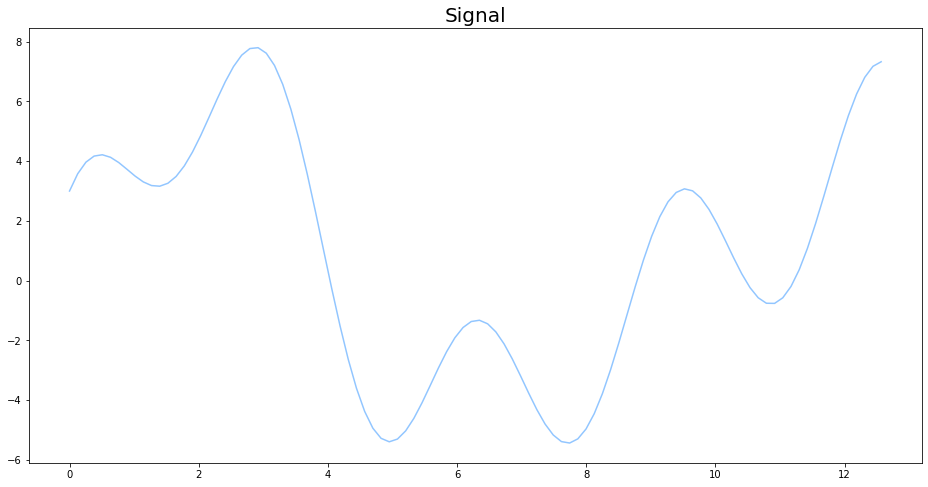

In [4]:
plt.figure(figsize=(16, 8))
plt.title('Signal', fontsize=20)

plt.plot(data_x, data_y, label='correct signal')

In [5]:
def rbf(x, x_prime, theta_1, theta_2):
    """RBF Kernel

    Args:
        x (float): data
        x_prime (float): data
        theta_1 (float): hyper parameter
        theta_2 (float): hyper parameter
    """
    
    return theta_1 * np.exp(-1 * (x - x_prime)**2 / theta_2)

def periodic(x, x_prime, theta_1, theta_2):
    """Periodic Kernel

    Args:
        x (float): data
        x_prime (float): data
        theta_1 (float): hyper parameter
        theta_2 (float): hyper parameter
    """
    
    return np.exp(theta_1 * np.cos((x - x_prime) /theta_2))

def linear(x, x_prime, theta):
    """Linear Kernel

    Args:
        x (float): data
        x_prime (float): data
        theta (float): hyper parameter
    """
    
    return x * x_prime + theta

def exp(x, x_prime, theta):
    """Linear Kernel

    Args:
        x (float): data
        x_prime (float): data
        theta (float): hyper parameter
    """
    
    return np.exp(-np.abs(x - x_prime) / theta)

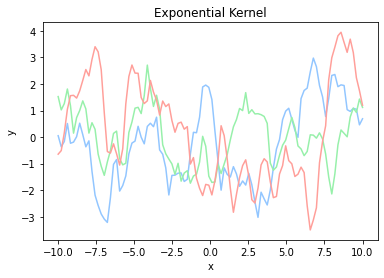

In [6]:
def plot_kernel(kernel, title):
    n = 100
    x = np.linspace(-10, 10, n)
    ys = []
    
    for i in range(3):
        mkernel = np.zeros((x.shape[0], x.shape[0]))
        for i_row in range(x.shape[0]):
            for i_col in range(i_row, x.shape[0]):
                mkernel[i_row, i_col] = kernel(x[i_row], x[i_col])
                mkernel[i_col, i_row] = mkernel[i_row, i_col]
        
        K = 1**2 * np.dot(mkernel, mkernel.T)
        y = np.random.multivariate_normal(np.zeros(len(x)), K)
        ys.append(y)
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    for y in ys:
        ax.plot(x, y)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'{title}')

plot_kernel(lambda x, x_prime: exp(x, x_prime, 0.5), 'Exponential Kernel')

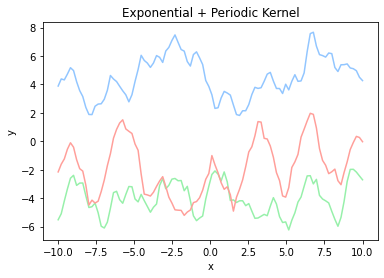

In [7]:
kernel = lambda x, x_prime: 0.8 * exp(x, x_prime, 0.5) + 0.2 * periodic(x, x_prime, 0.5, 0.5)
plot_kernel(kernel, 'Exponential + Periodic Kernel')

In [10]:
def train_test_split(x, y, test_size):
    assert len(x) == len(y)
    n_samples = len(x)
    test_indices = np.sort(
        np.random.choice(
            np.arange(n), int(
                n_samples * test_size), replace=False))
    train_indices = np.ones(n_samples, dtype=bool)
    train_indices[test_indices] = False
    test_indices = ~ train_indices

    return x[train_indices], x[test_indices], y[train_indices], y[test_indices]


n = 100
data_x = np.linspace(0, 4 * np.pi, n)
data_y = objective(data_x)


x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.70)

def gpr(x_train, y_train, x_test):
    # average
    mu = []
    # variance
    var = []

    train_length = len(x_train)
    test_length = len(x_test)

    K = np.zeros((train_length, train_length))
    for x_idx in range(train_length):
        for x_prime_idx in range(train_length):
            K[x_idx, x_prime_idx] = rbf(x_train[x_idx], x_train[x_prime_idx], theta_1=1.0, theta_2=1.0)

    yy = np.dot(np.linalg.inv(K), y_train)

    for x_test_idx in range(test_length):
        k = np.zeros((train_length,))
        for x_idx in range(train_length):
            k[x_idx] = rbf(
                x_train[x_idx],
                x_test[x_test_idx],
                theta_1=1.0, theta_2=1.0)
        s = rbf(
            x_test[x_test_idx],
            x_test[x_test_idx],
            theta_1=1.0, theta_2=1.0)
        mu.append(np.dot(k, yy))
        kK_ = np.dot(k, np.linalg.inv(K))
        var.append(s - np.dot(kK_, k.T))
    return mu, var

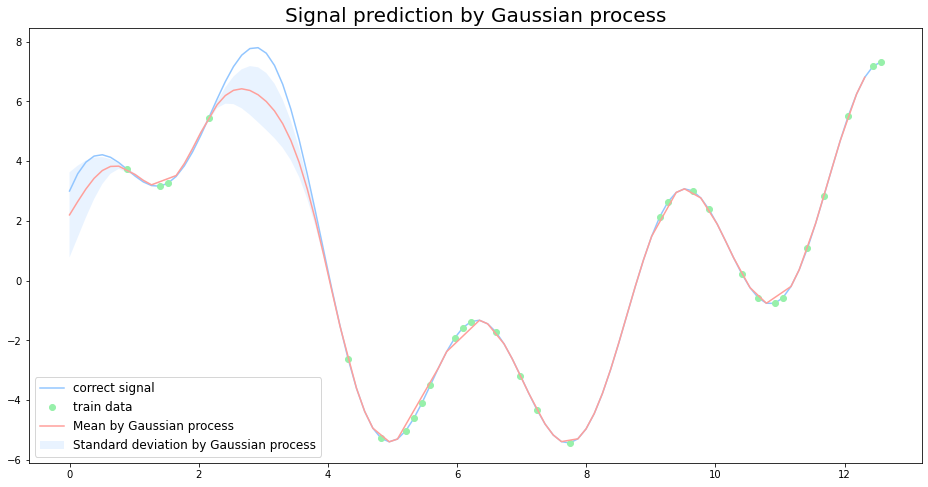

In [15]:
def plot_gpr(x_train, y_train, x_test, mu, var):
    plt.figure(figsize=(16, 8))
    plt.title('Gaussian Process Regressor', fontsize=20)

    plt.plot(data_x, data_y, label='objective')
    plt.plot(
        x_train,
        y_train,
        'o',
        label='train data')

    std = np.sqrt(np.abs(var))

    plt.plot(x_test, mu, label='Mean')

    plt.fill_between(
        x_test,
        mu + 2 * std,
        mu - 2 * std,
        alpha=.2,
        label='Standard deviation')
    plt.legend(
        loc='lower left',
        fontsize=12)

    plt.savefig('gpr.png')


mu, var = gpr(x_train, y_train, x_test)
plot_gpr(x_train, y_train, x_test, mu, var)


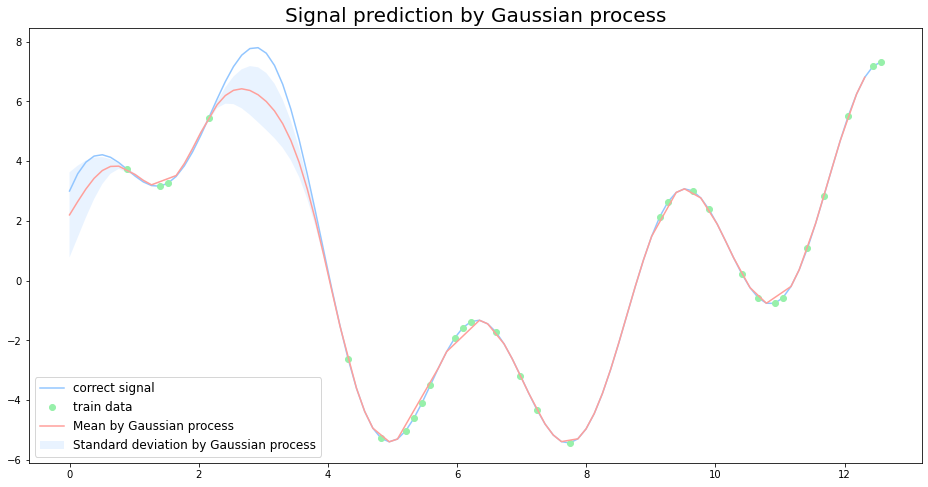

In [17]:
def gpr(x_train, y_train, x_test, kernel):
    # average
    mu = []
    # variance
    var = []

    train_length = len(x_train)
    test_length = len(x_test)

    K = np.zeros((train_length, train_length))
    for x_idx in range(train_length):
        for x_prime_idx in range(train_length):
            K[x_idx, x_prime_idx] = kernel(x_train[x_idx], x_train[x_prime_idx])

    yy = np.dot(np.linalg.inv(K), y_train)

    for x_test_idx in range(test_length):
        k = np.zeros((train_length,))
        for x_idx in range(train_length):
            k[x_idx] = kernel(
                x_train[x_idx],
                x_test[x_test_idx])
        s = kernel(
            x_test[x_test_idx],
            x_test[x_test_idx])
        mu.append(np.dot(k, yy))
        kK_ = np.dot(k, np.linalg.inv(K))
        var.append(s - np.dot(kK_, k.T))
    return mu, var

mu, var = gpr(x_train, y_train, x_test, lambda x, x_prime : rbf(x, x_prime, theta_1=1.0, theta_2=1.0))
plot_gpr(x_train, y_train, x_test, mu, var)

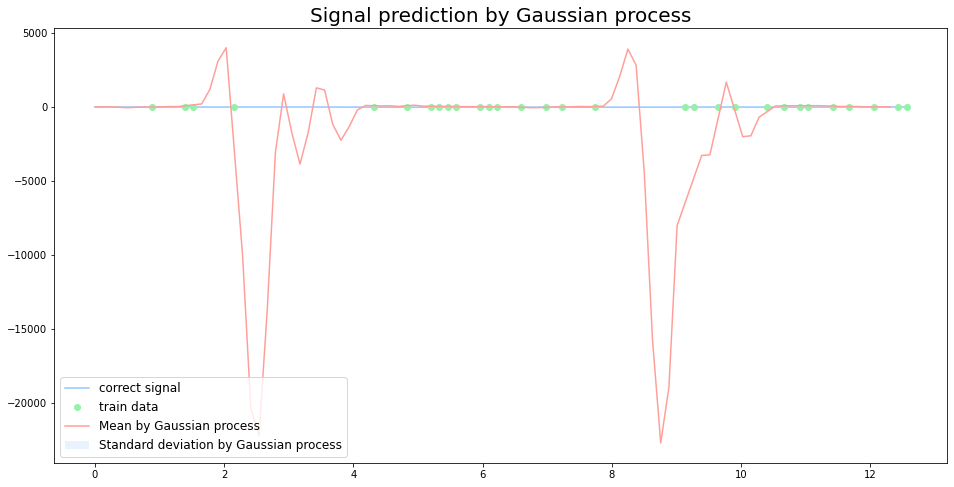

In [18]:
mu, var = gpr(x_train, y_train, x_test, lambda x, x_prime : periodic(x, x_prime, theta_1=1.0, theta_2=1.0))
plot_gpr(x_train, y_train, x_test, mu, var)

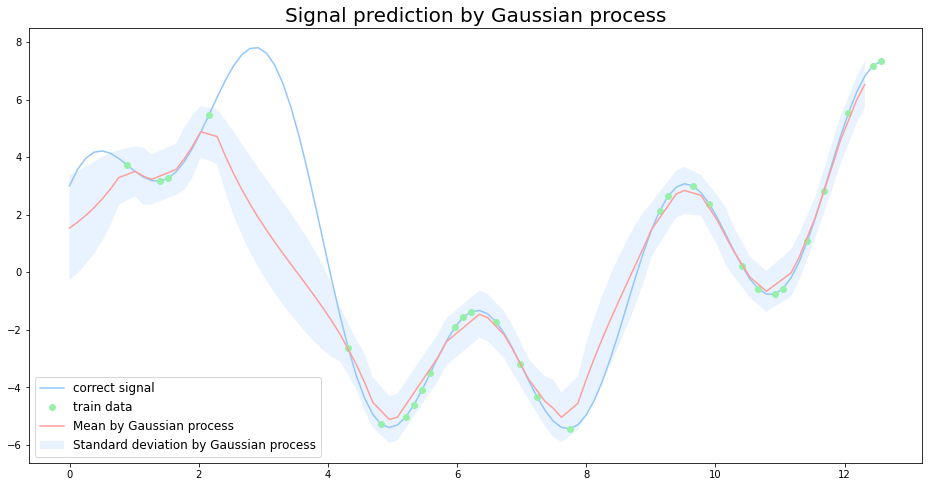

In [20]:
mu, var = gpr(x_train, y_train, x_test, lambda x, x_prime : exp(x, x_prime, theta=1.0))
plot_gpr(x_train, y_train, x_test, mu, var)

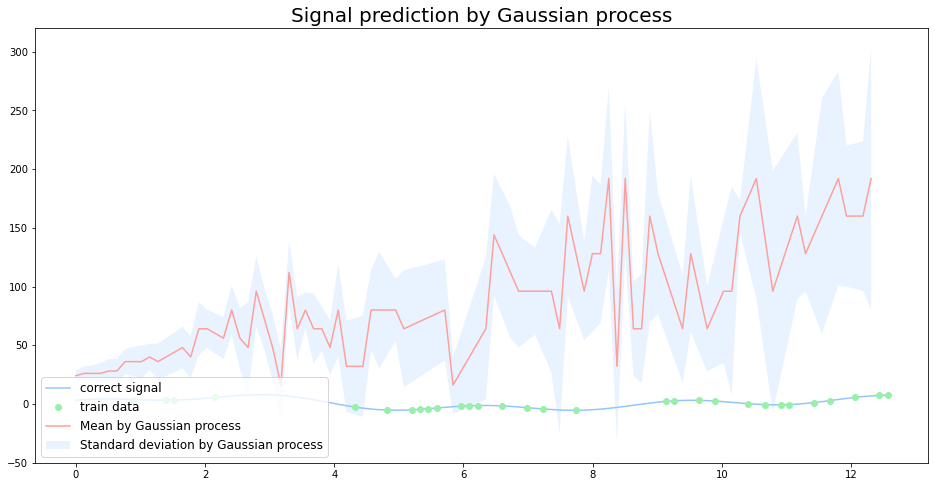

In [21]:
mu, var = gpr(x_train, y_train, x_test, lambda x, x_prime : linear(x, x_prime, theta=1.0))
plot_gpr(x_train, y_train, x_test, mu, var)